# Load and Preprocess the scRNA-seq Data

Load the "NormanWeissman2019_filtered" dataset:

In [1]:
import os

import pertdata as pt

NormanWeissman2019_filtered = pt.PertDataset(
    name="NormanWeissman2019_filtered",
    cache_dir_path=os.path.join("..", "cache", "pertdata"),
)
print(NormanWeissman2019_filtered)
adata = NormanWeissman2019_filtered.adata

Dataset already cached: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered
Loading: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered/adata.h5ad
PertDataset object
    name: NormanWeissman2019_filtered
    cache_dir_path: /workspaces/transmet/cache/pertdata
    path: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered
    adata: AnnData object with n_obs ✕ n_vars = 111445 ✕ 33694


In [2]:
from typing import Optional

import numpy as np
from anndata import AnnData


def equal_subsampling(
    adata: AnnData, obs_key: str = "perturbation", n_min: Optional[int] = None
) -> AnnData:
    """Subsample cells while retaining same class sizes.

    Classes are given by obs_key pointing to categorical in adata.obs.
    If n_min is given, downsamples to at least this number instead of the number
    of cells in the smallest class and throws out classes with less than n_min cells.

    Args:
        adata: Annotated data matrix.
        obs_key: Key in adata.obs specifying the groups to consider.
        n_min: If given, downsample to at least this number instead of the number of
            cells in the smallest class and throws out classes with less than n_min
            cells.

    Returns:
        Subsampled version of the original annotated data matrix.
    """
    counts = adata.obs[obs_key].value_counts()
    if n_min is not None:
        # Ignore groups with less than n_min cells to begin with.
        groups = counts.index[counts >= n_min]
    else:
        groups = counts.index

    # We select downsampling target counts by min-max, i.e. the largest n such that
    # every group has at least n cells before downsampling.
    n = np.min(counts)
    n = n if n_min is None else np.max([n_min, n])

    # Subsample indexes per group.
    indexes = [
        np.random.choice(
            adata.obs_names[adata.obs[obs_key] == group], size=n, replace=False
        )
        for group in groups
    ]
    selection = np.hstack(np.array(indexes))

    return adata[selection].copy()

In [3]:
import scanpy as sc

if "processed" not in adata.uns.keys():
    adata.layers["counts"] = adata.X.copy()

    # Filtering.
    print("Filtering...")
    sc.pp.filter_cells(data=adata, min_counts=1000)
    sc.pp.normalize_per_cell(data=adata)
    sc.pp.filter_genes(data=adata, min_cells=50)
    sc.pp.log1p(adata)

    # High class imbalance.
    print("Equal subsampling...")
    adata = equal_subsampling(adata, "perturbation", n_min=200)
    sc.pp.filter_genes(adata, min_cells=3)

    # Select highly variable genes.
    print("Selecting highly variable genes...")
    n_var_max = 2000
    sc.pp.highly_variable_genes(
        adata, n_top_genes=n_var_max, layer="counts", flavor="seurat_v3"
    )

    # PCA.
    print("Running PCA...")
    sc.pp.pca(adata, mask_var="highly_variable")

    # Neighbors.
    print("Computing neighbors...")
    sc.pp.neighbors(adata=adata)

    adata.uns["processed"] = True

Filtering...
Equal subsampling...
Selecting highly variable genes...
Running PCA...
Computing neighbors...


# E-Distance Computation

The E-distance relates the width of cell distributions of high-dimensional molecular profiles to their distance from each other.
A large E-distance of perturbed cells from unperturbed indicates a strong change in molecular profile induced by the perturbation.

In [4]:
import scperturb

estats = scperturb.edist(
    adata=adata, obs_key="perturbation", obsm_key="X_pca", dist="sqeuclidean"
)

# Square matrix, all pairs of perturbations get an E-distance.
estats.head()

100%|██████████| 19306/19306 [02:29<00:00, 129.20it/s]


perturbation,control,KLF1,BAK1,CEBPE,CEBPE_RUNX1T1,UBASH3B,ETS2,TBX3_TBX2,OSR2,SLC4A1,...,CEBPE_CNN1,HNF4A,ARID1A,CDKN1C,POU3F2_CBFA2T3,FOXA3_FOXA1,FOXO4,CITED1,CEBPB_OSR2,FOXF1_HOXB9
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,28.237099,0.129828,86.662191,42.172116,14.306733,28.754211,56.234395,27.082459,20.134182,...,39.294650,57.059364,69.239286,41.949787,61.779117,75.969752,45.294656,42.341498,125.021732,69.833493
KLF1,28.237099,0.000000,31.219350,147.758982,98.531490,49.598960,76.894906,102.030726,63.937632,68.944708,...,88.141867,111.321642,126.673257,76.599304,120.330139,127.704826,98.315620,92.358431,181.159899,126.474158
BAK1,0.129828,31.219350,0.000000,89.092190,43.495027,18.270214,26.543624,58.745807,27.208405,20.583295,...,44.115192,61.470497,72.180964,47.877390,65.173688,79.428251,49.156145,46.875655,126.431222,72.330012
CEBPE,86.662191,147.758982,89.092190,0.000000,9.082487,72.339808,51.329511,86.986582,48.273622,73.839283,...,25.185236,53.581587,64.994811,67.929295,49.299794,63.403470,51.716372,42.919355,15.969031,42.264496
CEBPE_RUNX1T1,42.172116,98.531490,43.495027,9.082487,0.000000,39.644692,22.900834,63.055882,21.774233,38.164209,...,13.597927,40.815343,55.909624,48.223195,40.405167,57.207523,36.501897,28.673084,33.571840,38.470930


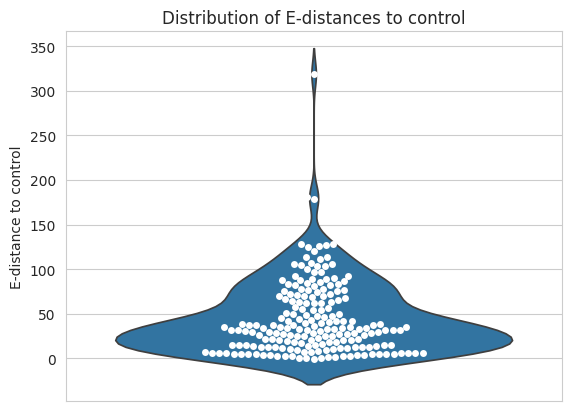

In [5]:
import matplotlib.pyplot as pt
import seaborn as sns

with sns.axes_style(style="whitegrid"):
    sns.violinplot(data=estats.loc["control"], inner=None)
    sns.swarmplot(data=estats.loc["control"], size=5, color="white")
pt.xticks(ticks=[0], labels=[""])
pt.ylabel("E-distance to control")
pt.title("Distribution of E-distances to control")
pt.show()

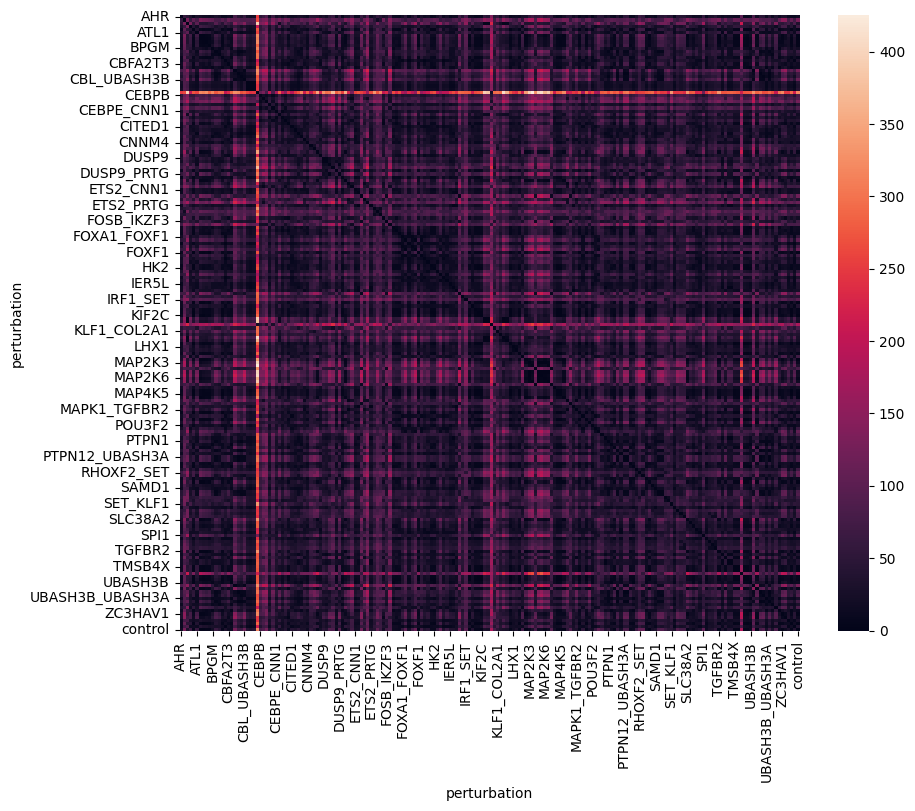

In [6]:
fig, ax = pt.subplots(nrows=1, ncols=1, figsize=[10, 8])
order = estats.sort_index().index
sns.heatmap(data=estats.loc[order, order])
pt.show()